#Bibliotecas


In [1]:
import pandas as pd
import requests as rq
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from google.colab import drive
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error
import itertools
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler


In [2]:
#Definição de semente para garantir reprodutibilidade do modelo.
np.random.seed(42)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
simplefilter(action='ignore', category=FutureWarning)

#Carregamento dos dados

In [5]:
df = pd.read_csv('drive/MyDrive/Projeto TCC Pós Graduação/nfl-big-data-bowl-2020/train.csv', low_memory=False)

#Pré Processamento dos dados

##Adição de coluna ResultAfterMove
Adicionado nova feature ao dataset mapeando o resultado de cada jogada, a jogada pode ter resultado em avanço em campo, ganho de novas descidas, turn over on Downs, quando a bola retorna para o outro time ou retornar nenhum avanço ou recuo em campo. 

In [6]:
df['ResultAfterMove'] = np.where(df['Yards']<0,'Perda de jardas',np.where(df['Yards']>=df['Distance'],'FirstDown',np.where(df['Down']==4,'Turn Over on Downs',np.where(['Yards']==0,'Sem avanço','Avanco sem First Down'))))

##Colunas Key e IsHomeTeam
Adicionado coluna Key, concatenando GameID e PlayID, a qual será utilizada como indice do dataset. A coluna IsHomeTeam foi adicionada, mapenado em cada jogada se o time com posse de bola era o time mandante do jogo ou não. 

In [7]:
df['key'] = df['GameId'].map(str)+'-'+df['PlayId'].map(str)
df['IsHomeTeam'] = df['Team'].map({'away': 0, 'home': 1})
df = df.drop(df[['GameId','PlayId','Team']],axis=1)
df = df.set_index('key')

##Separação entre atributos e variável alvo

In [8]:
X,y = df.drop('Yards',axis=1), df['Yards']

##Plot de distruição atributo alvo

<ipython-input-9-192c765dac2a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y.values)


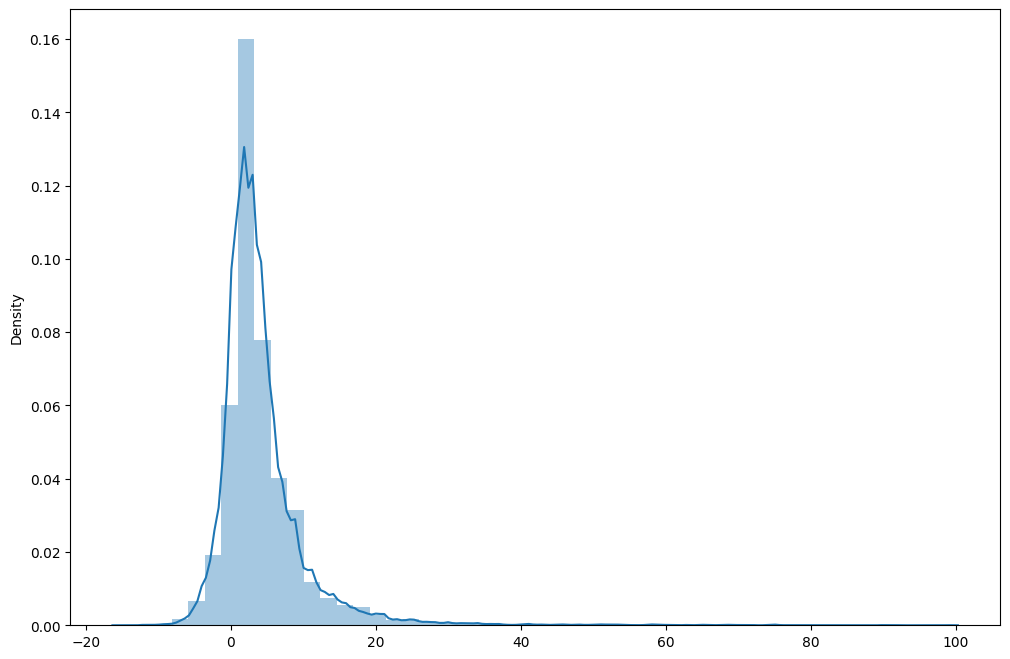

In [9]:
ax = sns.distplot(y.values)
ax.figure.set_size_inches(12,8)

##Plot CountValues por resultado de jogada e temporada.

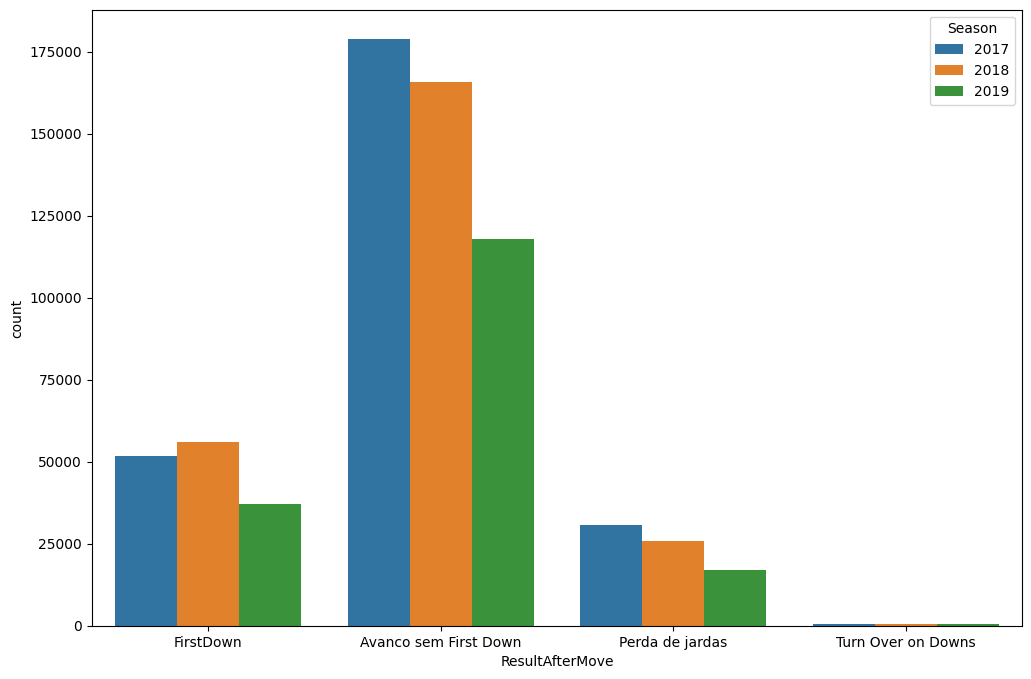

In [10]:
ax = sns.countplot(x=df['ResultAfterMove'],hue=df['Season'])
ax.figure.set_size_inches(12, 8)

##Separação do dataset entre Treino e Teste
Utilização de y para estratificação dos dados e divisão entre 70/30

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, stratify=y)

##Validação de colunas com informações nulas

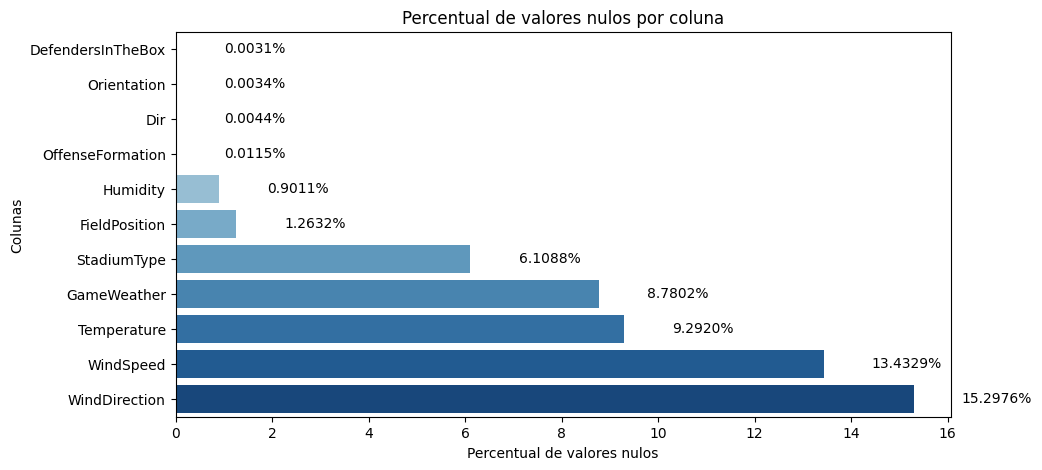

In [12]:
percent_nulos = X_train.isnull().sum() / len(X_train) * 100
percent_nulos = percent_nulos[percent_nulos != 0]
percent_nulos = percent_nulos.sort_values()
# Criando um gráfico de barras horizontais com os percentuais de valores nulos
plt.figure(figsize=(10,5))
ax = sns.barplot(x=percent_nulos, y=percent_nulos.index, palette='Blues')
ax.set_title('Percentual de valores nulos por coluna')
ax.set_xlabel('Percentual de valores nulos')
ax.set_ylabel('Colunas')
for i, v in enumerate(percent_nulos):
    ax.text(v + 1, i + .1, f'{v:.4f}%', color='black', fontweight='light')
plt.show()

##Processamento da coluna WindSpeed
Função desenvolvida para aplicar a padronização dos dados da coluna WindSpeed seguindo a seguinte lógica:
Em casos que são numéricos, retornará o valor, caso o valor numérico contenha texto junto, ex: mph, retornará apenas o valor numérico. Em casos de range de valores, por exemplo "30 - 50", será realizado uma média entre os dois valores e o valor será o retorno deste calculo.

In [13]:
def windspeed(x):
    x=str(x)
    if x.isdigit():
        return int(x)
    elif (x.isalpha()):
        return 0
    elif (x.isalnum()):
        return int(x.upper().split('M')[0])
    elif '-' in x:
        return int((int(x.split('-')[0])+int(x.split('-')[1]))/2)
    else:
        return 0

##Aplicação da função e preenchimento de valores nulos com a média da coluna.

In [14]:
#dataset de treino
X_train['WindSpeed']=X_train['WindSpeed'].apply(windspeed)
X_train['WindSpeed'].fillna(X_train['WindSpeed'].mean(),inplace=True)

In [15]:
#dataset de teste
X_test['WindSpeed']=X_test['WindSpeed'].apply(windspeed)
X_test['WindSpeed'].fillna(X_test['WindSpeed'].mean(),inplace=True)

In [16]:
X_train['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

In [17]:
X_test['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

<ipython-input-18-fcff65064d60>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train['WindSpeed'])


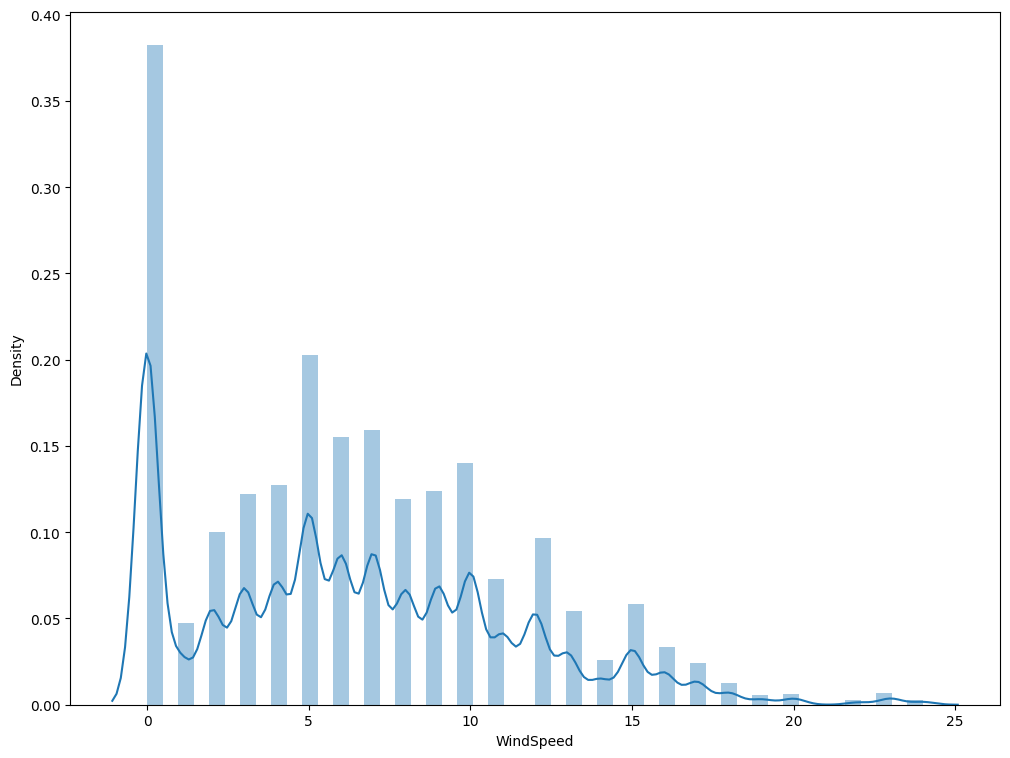

In [18]:
ax = sns.distplot(X_train['WindSpeed'])
ax.figure.set_size_inches(12,9)

##Processamento da coluna Wind Direction. 
Função para limpeza da coluna Wind Direction, devido a diversisdade de valores, foram mapeadas todas as possibilidades existentes no dataset e a função abaixo fará a substituição destes entre North, South, West, East, South West e North West.

In [19]:
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'N/A'

#Aplicação da função nos dados de treino
X_train['WindDirection'] = X_train['WindDirection'].apply(clean_wind_direction)

In [20]:
#Aplicação da função nos dados de teste
X_test['WindDirection'] = X_test['WindDirection'].apply(clean_wind_direction)

In [21]:
X_train['WindDirection'].unique()

array(['south east', 'N/A', 'south', 'north', 'south west', 'west',
       'north east', 'north west', 'east'], dtype=object)

##Processamento das colunas Humidity e Temperature
Aplicado o preenchimento de valores nulos das colunas Humidity e Temperature utilizando o método ffill, 'Forward Fill', o qual realiza o preenchimento replicando o valor da linha anterior. Devido a forma de preenchimento destes dados, com poucas variações em um curto espaço de tempo, o método retorna um bom resultado para tratamento de valores nulos.

In [22]:
#Dados de treino
X_train['Humidity'].fillna(method='ffill', inplace=True)
X_train['Temperature'].fillna(method='ffill', inplace=True)

In [23]:
#Dados de teste
X_test['Humidity'].fillna(method='ffill', inplace=True)
X_test['Temperature'].fillna(method='ffill', inplace=True)

##Processamento de colunas Orientation, Dir, Deffenders e OffenseFormation
Preenchimento das colunas usando a média da coluna para as variáveis Orientation, Dir, DeffendersInTheBox e OffenseFormation. 
Para a coluna OffenseFormation, a utilização de jogadas é algo totalmente importante, particular e decisivo em um jogo, porém existem jogadas personalizadas em cada time, então, para os valores em branco, foi assumido o valor UNKNOWN.

<ipython-input-24-ec7770de7b0f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train['Orientation'])


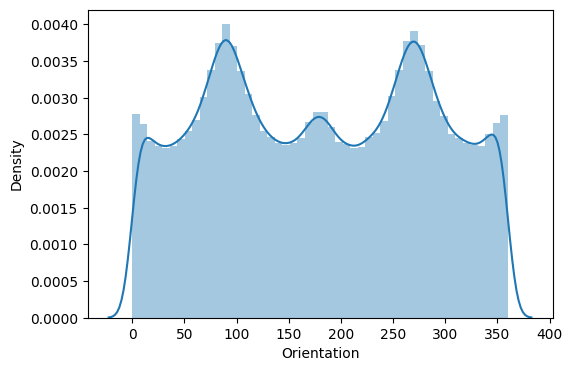

In [24]:
ax = sns.distplot(X_train['Orientation'])
ax.figure.set_size_inches(6,4)

<ipython-input-25-10a12caa2e14>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(X_train['Dir'])


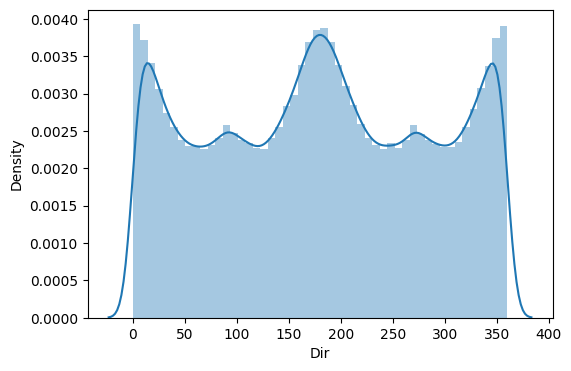

In [25]:
ax = sns.distplot(X_train['Dir'])
ax.figure.set_size_inches(6,4)

In [26]:
na_map = {
    'Orientation': X_train['Orientation'].mean(),
    'Dir': X_train['Dir'].mean(),
    'DefendersInTheBox': np.math.ceil(X_train['DefendersInTheBox'].mean()),
    'OffenseFormation': 'UNKNOWN'
}

#Preenchimento no dataset de teste
X_train.fillna(na_map, inplace=True)

In [27]:
#Preenchimento no dataset de treino
X_test.fillna(na_map, inplace=True)

##Processamento da coluna Game Weather
Devido a alta diversidade de valores, totalmente fora de um padrão, para a padronização desta variável, foram mapeados todos os valores possíveis e agrupados enre Rain, Overcast, Clear, Snow e Controlled, para casos de estadios fechados, onde o clima não terá tanta influência.

In [28]:
def group_game_weather(weather):
    rain = ['Rainy', 'Rain Chance 40%', 'Showers',
            'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
            'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']

    overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
                'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
                'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
                'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
                'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
                'Partly Cloudy', 'Cloudy']

    clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
             'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
             'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
             'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
             'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
             'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']

    snow  = ['Heavy lake effect snow', 'Snow']

    controlled  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 'rain'
    elif weather in overcast:
        return 'overcast'
    elif weather in clear:
        return 'clear'
    elif weather in snow:
        return 'snow'
    elif weather in controlled:
        return 'controlled'
    
    return 'controlled'

In [29]:
#Aplicação da função nos dados de treino
X_train['GameWeather'] = X_train['GameWeather'].apply(group_game_weather)


In [30]:
#Aplicação da função nos dados de teste
X_test['GameWeather'] = X_test['GameWeather'].apply(group_game_weather)


##Processamento da coluna FieldPosition. 

In [31]:
#dados de treino
X_train['FieldPosition'] = np.where(X_train['YardLine'] == 50, X_train['PossessionTeam'], X_train['FieldPosition'])
#dados de teste
X_test['FieldPosition'] = np.where(X_test['YardLine'] == 50, X_test['PossessionTeam'], X_test['FieldPosition'])

##Processamento da coluna Stadium Type
Para esta variável, temos um cenário parecido com a Game Weather, existem vários valores que, no fim, possuem o mesmo significado. Para tal, foram mapeados todos os valores possíveis da coluna e agrupados entre Outdoor, Indoor_Closed, Indoor_Open, Dome_Closed, Dome_Open, casos nulos serão preenchidos com a tag unknown.

In [32]:
#Para a coluna de Stadium Type, também foi realizado o agrupado dos valores, visto que temos valores que diferem, porém possuem o mesmo significado.
def group_stadium_types(stadium):
    outdoor = ['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
               'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
               'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']

    indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
                    'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',]

    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']

    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 'outdoor'
    elif stadium in indoor_closed:
        return 'indoor closed'
    elif stadium in indoor_open:
        return 'indoor open'
    elif stadium in dome_closed:
        return 'dome closed'
    elif stadium in dome_open:
        return 'dome open'
    else:
        return 'unknown'
#Aplicação nos dados de treino.   
X_train['StadiumType'] = X_train['StadiumType'].apply(group_stadium_types)

In [33]:
#Aplicação nos dados de teste
X_test['StadiumType'] = X_test['StadiumType'].apply(group_stadium_types)

##Processamento coluna PlayerHeight
Para esta coluna, como o dado já traz uma informação numérica com a altura do jogador, temos apenas algumas situações onde existem alguma string acompanhando, neste caso, foi removido o string que acompanhava o caracter numérico e, posteriormente, a coluna poderá ser transformada em um atributo numérico. 

In [34]:
#Aplicação no dados de treino
X_train['PlayerHeight']=X_train['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [35]:
#Aplicação nos dados de teste
X_test['PlayerHeight']=X_test['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [36]:
X_train['PlayerHeight'].unique()

array([5.5, 5. , 3.5, 4. , 8. , 4.5, 3. , 7.5, 6. , 7. , 6.5])

##Processamento coluna DefensePersonnel
Para esta coluna, onde temos a informação de quais e quantos jogadores compõem a linha de defesa do time, o dado encontra-se no formato do exemplo "1 DL, 3 LB, 4 BL, 2 OL", para efetuar a limpeza e processamento, foi aplicado a técnica de separar cada posição em uma coluna distinta, retornando quantos jogadores existem em cada uma delas, para tal, primeiro foi efetuado o split dos dados pelo espaço aplicado e depois coletado apenas o valor inteiro restante, cada valor deste foi armazenado em uma variável auxiliar (u, v, x e y) e na sequência, as novas colunas foram atribuídas ao dataset, tendo o seu nome conforme o nome da posição do jogador.

In [37]:
def process_defense(x):
    num=[]
    num=x.split(',')
    dl=int(num[0].split(' ')[0])
    lb=int(num[1].split(' ')[1])
    db=int(num[2].split(' ')[1])
    if(len(num)>3):
         ol=int(num[3].split(' ')[1])
    else:
         ol=0
    return [dl,lb,db,ol]

#Aplicação nos dados de treino
values=X_train['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_train['DL']=u
X_train['LB']=v
X_train['BL']=x
X_train['OL']=y
X_train.drop(['DefensePersonnel'],axis=1,inplace=True)

In [38]:
#Aplicação nos dados de teste
values=X_test['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_test['DL']=u
X_test['LB']=v
X_test['BL']=x
X_test['OL']=y
X_test.drop(['DefensePersonnel'],axis=1,inplace=True)

##Enconding dos dados
Nesta etapa, é realizado o enconding dos dados, primeiramente, existe a tentativa de converter todas as colunas que são diferentes do tipo INT para float16, as colunas que não puderem ser convertidas, retornarão no except e serão adicionadas em uma lista, a qual é passada ao método LabelEncoder, onde os valores das colunas serão rotulados com um numero inteiro para cada valor possível. 

In [39]:
#Aplicação nos dados de treino
ColumnsToEncoding=[]
for c in X_train.columns:
    if(X_train[c].dtype != int):
            try:
                X_train[c]=X_train[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_train[c].values)
    lbdic[c]=lb
    X_train[c]=lb.transform(X_train[c].values)

In [40]:
#Aplicação nos dados de teste
ColumnsToEncoding=[]
for c in X_test.columns:
    if(X_test[c].dtype != int):
            try:
                X_test[c]=X_test[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_test[c].values)
    lbdic[c]=lb
    X_test[c]=lb.transform(X_test[c].values)

In [41]:
X_test.head(5)

,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,...,Temperature,Humidity,WindSpeed,WindDirection,ResultAfterMove,IsHomeTeam,DL,LB,BL,OL
key,,,,,,,,,,,,,,,,,,,,,
2019102010-20191020101611,70.6875,28.656250,3.539062,3.160156,0.340088,41.6875,40.406250,2541199,1614,82,...,50.0,79.0,8,6,0,1,3,3,5,0
2018110403-20181104032991,97.9375,31.515625,4.089844,1.179688,0.409912,74.9375,63.656250,2533047,1887,82,...,53.0,49.0,16,0,0,1,4,3,4,0
2017111200-20171112003450,70.0000,21.953125,3.470703,2.169922,0.439941,233.5000,341.250000,2539240,1740,23,...,42.0,50.0,2,7,0,1,4,3,4,0
2019091507-20190915074129,66.4375,21.203125,2.679688,2.279297,0.270020,327.5000,275.750000,2558064,2210,90,...,81.0,51.0,3,5,0,1,2,4,5,0
2018120210-20181202103210,71.9375,25.656250,3.250000,3.089844,0.320068,78.2500,9.007812,2543592,131,53,...,57.0,52.0,6,7,1,0,3,3,5,0


##Feature Selection

Relizado teste empirico aplicando a remoção de colunas, uma a uma, e validando o resultado do modelo com o novo dataset. Ao final dos testes, a decisão foi de remover todas as colunas abaixo, generalizando o modelo, visto que todas as informações sobre posição inicial e final e informações de jogadores foram removidas. Desta forma conseguimos um resultado mais conciso do modelo, tendo uma maior taxa de erro, porém mais voltada à realidade.

In [43]:
X_Test_2 = X_test.drop(X_test[['X','Y','S','A','Dir','DisplayName','Dis','YardLine','NflIdRusher','GameClock','Orientation','PossessionTeam','NflId','FieldPosition','JerseyNumber', 'PlayerCollegeName', 'PlayerBirthDate', 'PlayerHeight', 'PlayerWeight','HomeScoreBeforePlay', 'VisitorScoreBeforePlay']], axis=1)
X_Test_2.head(10)

X_Train_2 = X_train.drop(X_train[['X','Y','S','A','Dir','DisplayName','Dis','YardLine','NflIdRusher','GameClock','Orientation','PossessionTeam','NflId','FieldPosition','JerseyNumber', 'PlayerCollegeName', 'PlayerBirthDate', 'PlayerHeight', 'PlayerWeight','HomeScoreBeforePlay', 'VisitorScoreBeforePlay']], axis=1)
X_Train_2.head(10)

,Season,Quarter,Down,Distance,OffenseFormation,OffensePersonnel,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,...,Temperature,Humidity,WindSpeed,WindDirection,ResultAfterMove,IsHomeTeam,DL,LB,BL,OL
key,,,,,,,,,,,,,,,,,,,,,
2017091700-20170917000316,2017,1,1,10,5,18,7.0,1,765,766,...,80.0,69.0,2,6,0,0,3,4,4,0
2017091004-20170910042640,2017,3,1,10,6,9,6.0,1,277,277,...,68.0,70.0,0,0,0,1,4,2,5,0
2017091706-20170917062911,2017,3,2,10,5,9,7.0,1,972,973,...,78.0,64.0,1,5,0,0,2,4,5,0
2017102211-20171022111001,2017,2,1,10,6,18,8.0,0,4665,4666,...,75.0,29.0,7,6,0,0,4,3,4,0
2018120206-20181202061336,2018,2,2,13,6,9,5.0,1,19603,19607,...,86.0,68.0,15,5,2,0,4,2,5,0
2017091100-20170911000230,2017,1,2,2,5,9,7.0,1,574,574,...,70.0,0.0,0,0,1,1,4,2,5,0
2017102900-20171029002343,2017,3,1,10,5,9,7.0,1,4972,4973,...,56.0,56.0,11,2,1,0,4,2,5,0
2018100708-20181007082121,2018,3,1,10,5,13,7.0,1,14946,14948,...,75.0,60.0,10,7,0,1,4,3,4,0
2018102100-20181021003093,2018,4,3,1,4,33,6.0,1,15864,15864,...,66.0,75.0,6,8,1,0,4,1,6,0


##Scaler de dados
Para padronizar os valores do dataset, fora tentado 3 métodos diferentes e avaliado a melhor performance dentre eles, para este cenário, o método MinMaxScaler apresentou uma performance superior aos demais. 

In [44]:
#Aplicação de scaler nos dados. MinMaxScaler apresentou a melhor performance nos modelos testados.
SS = StandardScaler()
MM = MinMaxScaler()
RS = RobustScaler()

X_train_scaled = MM.fit_transform(X_train)
X_test_scaled = MM.fit_transform(X_test)

#Treinamento de modelos

##LinearRegression
Modelo com pior performance

In [ ]:
reg = LinearRegression()

# Treinamento
reg.fit(X_train_scaled, y_train)

# Predições com modelo
pred_reg = reg.predict(X_test_scaled)

In [ ]:
# Avaliação de modelo
rmse_reg = np.sqrt(mean_squared_error(y_test, pred_reg))
r2_reg = r2_score(y_test, pred_reg)
mae_reg = mean_absolute_error(y_test, pred_reg)

print("Root Mean Squared Error: ", rmse_reg)
print("R2 Score: ", r2_reg)
print("Mean Absolute Error: ", mae_reg)

Mean Squared Error:  6.395929035222775
R2 Score:  0.016952971257381932
Mean Absolute Error:  3.786234598939409


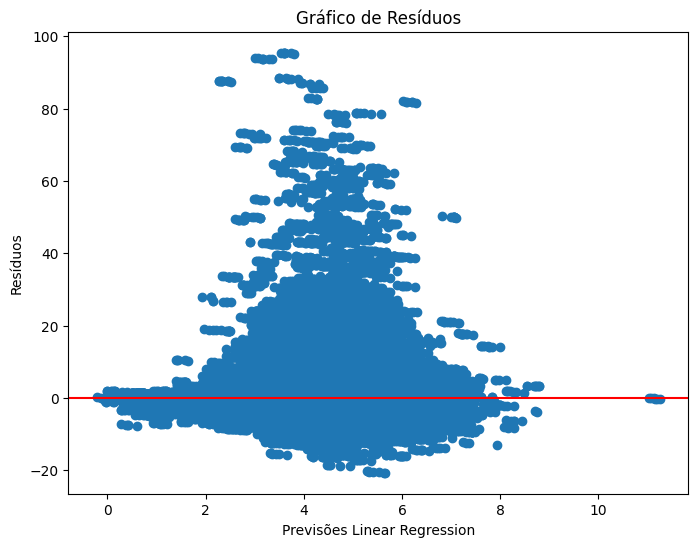

In [ ]:
# Plot do gráfico de resíduos do modelo.
residuals = y_test - pred_reg

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(pred_reg, residuals)
plt.xlabel('Previsões Linear Regression')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos')
plt.show()

##XGBoost Dados originais
O regressor XGBoost foi treinado com os dados antes de ser aplicado o scaler, como parametrização do modelo, foi alterado as informações de Max_Depth e ETA, os seguintes resultados foram obtidos. 

Mean Squared Error:  0.41

R2 Score:  99%

Mean Absolute Error:  0.11

In [ ]:
# Transformando conjuntos de treinamento e teste em DMatrices
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":20,
    "eta":0.1,
    "eval_metric":"rmse"
}

# Treinando o modelo
model_n = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds = model_n.predict(dtest)

In [ ]:
# Avaliar o modelo
rmse_n = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
mae_n = mean_absolute_error(y_test, preds)

print("Root Mean Squared Error: ", rmse_n)
print("R2 Score: ", r2)
print("Mean Absolute Error: ", mae_n)

Root Mean Squared Error:  0.4143513935302577
R2 Score:  0.9958742336491311
Mean Absolute Error:  0.11587124188280713


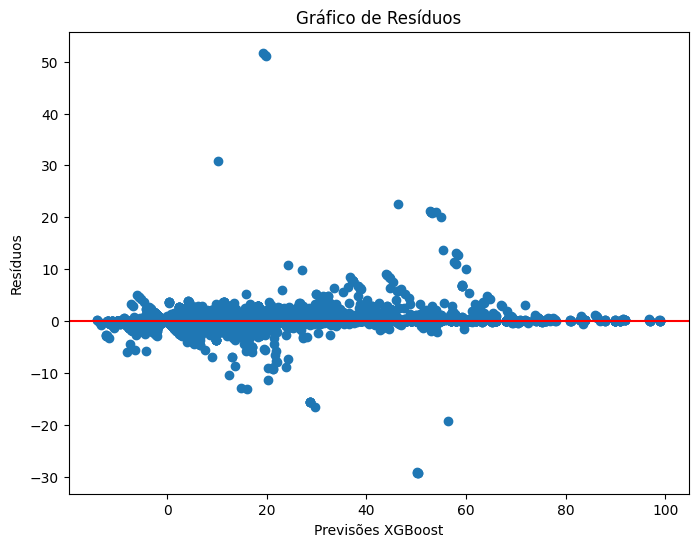

In [ ]:
# Plot do gráfico de resíduos do modelo.
residuals_xgb = y_test - preds

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals_xgb)
plt.xlabel('Previsões XGBoost')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos')
plt.show()

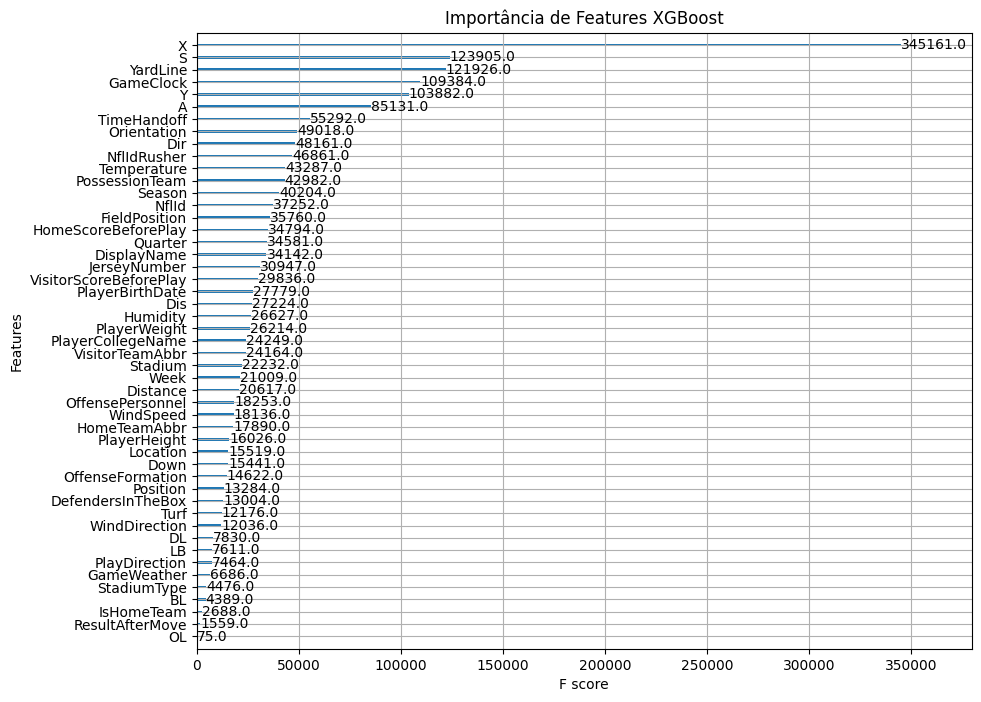

In [ ]:
#Grafico de importância de features
fig = plt.figure(figsize=(10, 8))
xgb.plot_importance(model_n, ax=plt.gca())
plt.title("Importância de Features XGBoost")
plt.show()

##Validação Cruzada XGBoost
Uso de validação cruzada com o XGBoost para averiguação de resultados no novo Dataset, após a aplicação do feature selection.

In [ ]:
#Usando validação cruzada
folds=5
model_cross = XGBRegressor(max_depth=20,eta=0.1)
result=model_selection.cross_val_score(model_cross, X_Train_2, y_train, cv=folds)
print("\nCross Validation Results %d folds: " % folds)
print("Mean R2 Accuracy: %.5f" % result.mean())
print("Mean STD: %.5f" % result.std())

predicted_cross = model_selection.cross_val_predict(model_cross, X_Train_2, y_train, cv=folds)


Cross Validation Results 5 folds: 
Mean R2 Accuracy: 0.99604
Mean STD: 0.00046


In [ ]:
print('Mean Absolute Error: %.2f' % mean_squared_error(y_train, predicted_cross))
print('Mean Absolute Error: %.2f' % r2_score(y_train, predicted_cross))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_train, predicted_cross))

Mean Absolute Error: 0.16
Mean Absolute Error: 1.00
Mean Absolute Error: 0.22


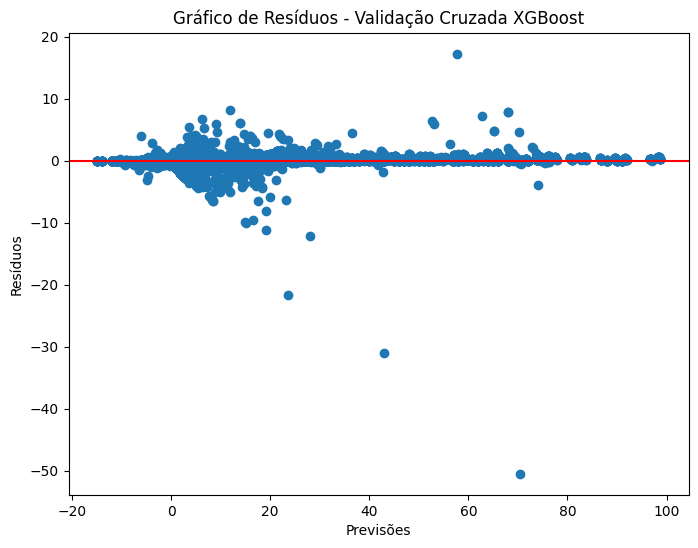

In [ ]:
# Plot do gráfico de resíduos do modelo.
residuals = y_train - predicted_cross

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(predicted_cross, residuals)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos - Validação Cruzada XGBoost')
plt.show()

##XGBoost Dados escalados
Em um segundo teste, o regressor XGBoost foi treinado com os dados já processados pelo MinMaxScaler, mantendo a mesma parametrização anterior e os seguintes resultados foram obtidos.

Mean Squared Error:  0.10

R2 Score:  99%

Mean Absolute Error:  0.10

In [ ]:
# Transformando conjuntos de treinamento e teste em DMatrices
dtrain_scaled = xgb.DMatrix(data=X_train_scaled, label=y_train)
dtest_scaled = xgb.DMatrix(data=X_test_scaled, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":20,
    "eta":0.1,
    "eval_metric":"rmse",
    "seed":42
}

# Treinando o modelo
model_n_scaled = xgb.train(params=params, dtrain=dtrain_scaled, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds_scaled = model_n_scaled.predict(dtest_scaled)

In [ ]:
# Avaliar o modelo
mse_n_scaled = mean_squared_error(y_test, preds_scaled)
r2_scaled = r2_score(y_test, preds_scaled)
mae_n_scaled = mean_absolute_error(y_test, preds_scaled)

print("Mean Squared Error: ", mse_n_scaled)
print("R2 Score: ", r2_scaled)
print("Mean Absolute Error: ", mae_n_scaled)

Mean Squared Error:  0.10545100401401007
R2 Score:  0.9974659350557045
Mean Absolute Error:  0.10472072952533532


In [ ]:
#Grafico de importância de features
fig = plt.figure(figsize=(15, 10))
xgb.plot_importance(model_n_scaled, ax=plt.gca())
plt.title("Importância de Features")
plt.show()

##Avaliação de Data Leakage
No modelo abaixo, avaliamos o treinamento usando o dataset após a remoção de diversas colunas, sendo estas, as que estavam caracterizando maior importância no modelo anterior, onde R2 bateu 99%

In [46]:
#Avaliação de possível vazamento de dados validado bom resultado.

# Transformando conjuntos de treinamento e teste em DMatrices
dtrain_2 = xgb.DMatrix(data=X_Train_2, label=y_train)
dtest_2 = xgb.DMatrix(data=X_Test_2, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":20,
    "eta":0.1,
    "eval_metric":"rmse"
}

# Treinando o modelo
model_data_leakage = xgb.train(params=params, dtrain=dtrain_2, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds_dl = model_data_leakage.predict(dtest_2)

In [47]:
# Avaliar o modelo
rmse_dl = np.sqrt(mean_squared_error(y_test, preds_dl))
r2_dl = r2_score(y_test, preds_dl)
mae_dl = mean_absolute_error(y_test, preds_dl)

print("Root Mean Squared Error: ", rmse_dl)
print("R2 Score: ", r2_dl)
print("Mean Absolute Error: ", mae_dl)

Root Mean Squared Error:  1.2509799277822764
R2 Score:  0.9623930853243017
Mean Absolute Error:  0.4693769284635384


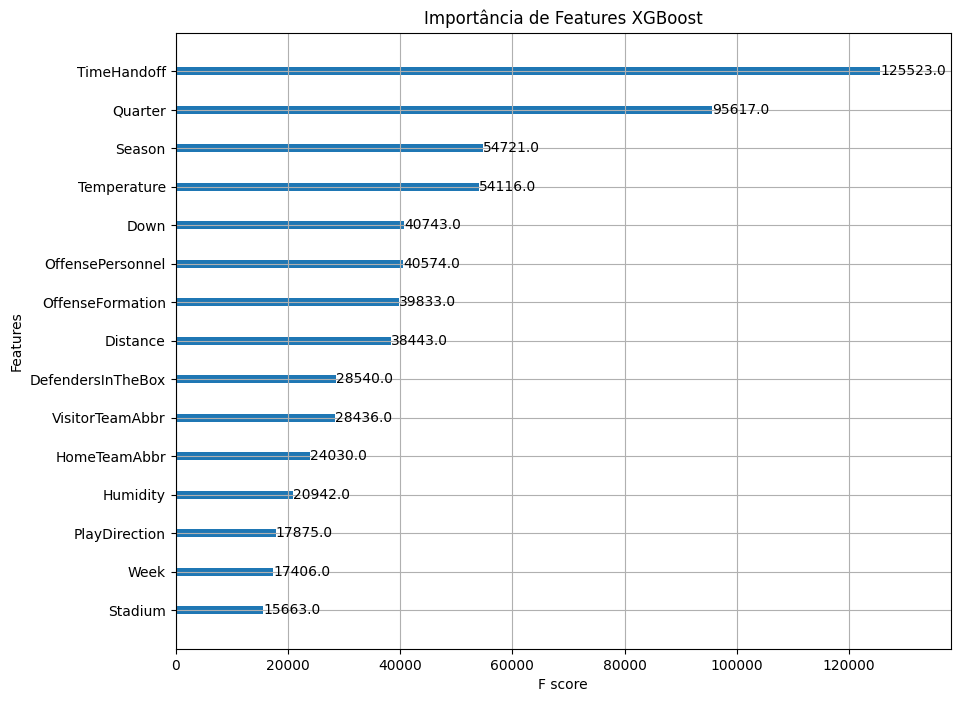

In [48]:
#Grafico de importância de features *top 15 features
fig = plt.figure(figsize=(10, 8))
xgb.plot_importance(model_data_leakage,max_num_features=15, ax=plt.gca())
plt.title("Importância de Features XGBoost")
plt.show()

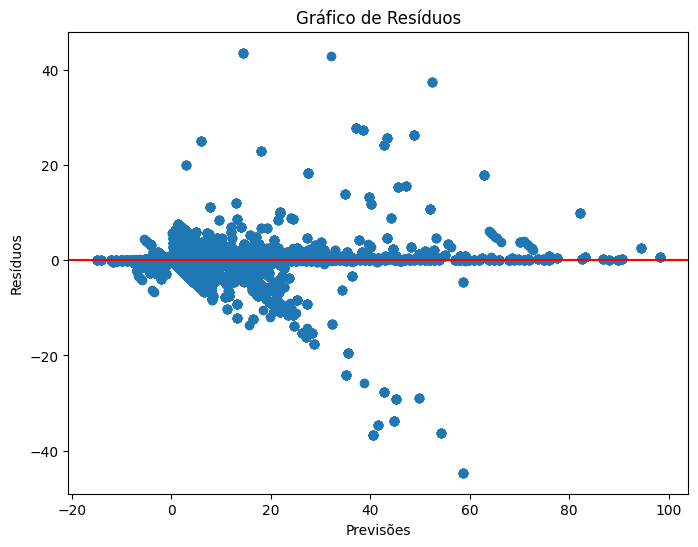

In [49]:
# Plot do gráfico de resíduos do modelo.
residuals_dl = y_test - preds_dl

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(preds_dl, residuals_dl)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos')
plt.show()

<ipython-input-50-0a89f0e025cb>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(preds_dl,)
<ipython-input-50-0a89f0e025cb>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test.values)


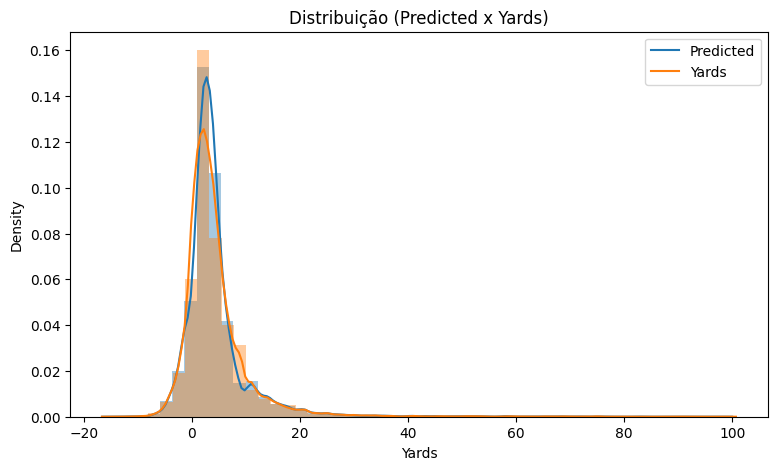

In [50]:
#Distribuição de jardas entre dados de teste e predições
graphs = []
ax = sns.distplot(preds_dl,)
ax = sns.distplot(y_test.values)
plt.legend(labels=["Predicted","Yards"])
plt.title('Distribuição (Predicted x Yards)')
plt.xlabel('Yards')
ax.figure.set_size_inches(9,5)

##LightGBM

In [51]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test)
model_gbm = lgb.train(params, train_data, num_boost_round=100)

preds_gbm = model_gbm.predict(X_test_scaled)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4707
[LightGBM] [Info] Number of data points in the train set: 477507, number of used features: 50
[LightGBM] [Info] Start training from score 4.227551


In [52]:
# Avaliar o modelo
rmse_gbm = np.sqrt(mean_squared_error(y_test, preds_gbm))
r2_gbm = r2_score(y_test, preds_gbm)
mae_gbm = mean_absolute_error(y_test, preds_gbm)

print("Root Mean Squared Error: ", rmse_gbm)
print("R2 Score: ", r2_gbm)
print("Mean Absolute Error: ", mae_gbm)

Root Mean Squared Error:  2.78246869756111
R2 Score:  0.8139508901520465
Mean Absolute Error:  2.0103742593072647


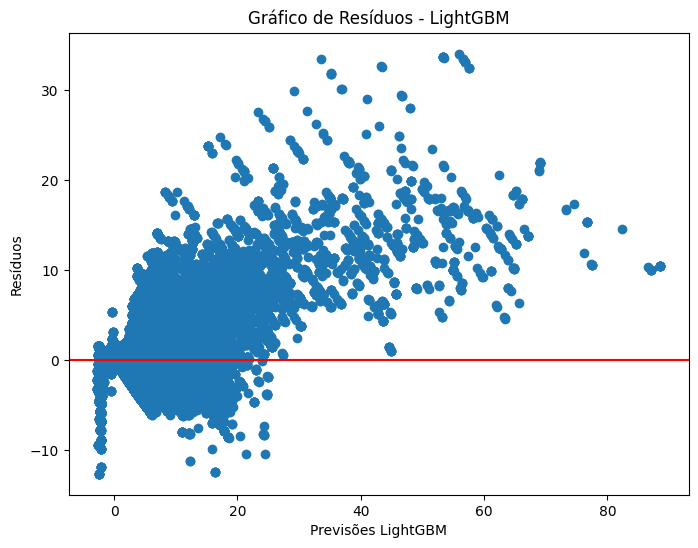

In [53]:
# Plot do gráfico de resíduos do modelo.
residuals_gbm = y_test - preds_gbm

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(preds_gbm, residuals_gbm)
plt.xlabel('Previsões LightGBM')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos - LightGBM')
plt.show()

##LightGBM Data Leakage
Apenas para fins de validação, foi utilizado o modelo LightGBM com o dataset após o feature selection, porém este obteve um decréscimo de acerto, por este motivo, não houve novos investimentos com este modelo.

In [55]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

train_data2 = lgb.Dataset(X_Train_2, label=y_train)
test_data2 = lgb.Dataset(X_Test_2, label=y_test)
model_gbm = lgb.train(params, train_data2, num_boost_round=100)

preds_gbm = model_gbm.predict(X_Test_2)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 477507, number of used features: 29
[LightGBM] [Info] Start training from score 4.227551


In [56]:
# Avaliar o modelo
rmse_gbm = np.sqrt(mean_squared_error(y_test, preds_gbm))
r2_gbm = r2_score(y_test, preds_gbm)
mae_gbm = mean_absolute_error(y_test, preds_gbm)

print("Root Mean Squared Error: ", rmse_gbm)
print("R2 Score: ", r2_gbm)
print("Mean Absolute Error: ", mae_gbm)

Root Mean Squared Error:  3.049918391513225
R2 Score:  0.7764660669262026
Mean Absolute Error:  2.0997683781866208
